# Evaluate a trained model

## Setup

```
jupyter nbextension enable --py widgetsnbextension
```

In [12]:

%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import pickle
import sys

from azureml.core import Workspace
import glob2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
from tqdm.notebook import tqdm

REPO_DIR = Path(os.getcwd()).parents[2]
sys.path.append(str(REPO_DIR))

from cgmml.common.evaluation.eval_utils import (
    preprocess_depthmap, preprocess, preprocess)
from cgmml.common.evaluation.evaluation_classes import Evaluation

In [13]:
sys.path.append(str(Path(os.getcwd()) / 'QA/eval_depthmap_models/src'))
import qa_config_height as CONFIG

In [14]:
DATA_CONFIG = CONFIG.DATA_CONFIG

# DATASET_PATH = str(REPO_DIR / "data/anon-depthmap-testset/scans/*/*/")
DATASET_PATH = str(REPO_DIR / "data/anon-realtime-testdata/scans/*/*/")

### Select the  model to be evaluated from workspace

In [15]:
workspace = Workspace.from_config()
selected_experiments = ["q3-depthmap-plaincnn-height-95k"]
RUN_ID = 'q3-depthmap-plaincnn-height-95k_1617983539_763a24b9'  # Run9
OUTPUT_DIR = 'data/logs/q3-depthmap-plaincnn-height-95k/run_03/'

### Download the models on your local system for evaluation

### Load the models

In [16]:
model_base_dir = REPO_DIR / f"data/{RUN_ID}"
evaluation = Evaluation(CONFIG.MODEL_CONFIG, CONFIG.DATA_CONFIG, model_base_dir, DATASET_PATH)
evaluation.get_the_model_path(workspace)

2021-08-13 14:38:20,647 - INFO - Model will download from 'outputs/best_model.ckpt' to '/Users/markus/Development/cgm/cgm-ml/data/q3-depthmap-plaincnn-height-95k_1617983539_763a24b9' - /Users/markus/Development/cgm/cgm-ml/cgmml/common/evaluation/evaluation_classes.py: line 48
INFO - Model will download from 'outputs/best_model.ckpt' to '/Users/markus/Development/cgm/cgm-ml/data/q3-depthmap-plaincnn-height-95k_1617983539_763a24b9'
2021-08-13 14:38:25,740 - INFO - Successfully downloaded model - /Users/markus/Development/cgm/cgm-ml/cgmml/common/evaluation/eval_utilities.py: line 425
INFO - Successfully downloaded model
2021-08-13 14:38:25,742 - INFO - Model was downloaded - /Users/markus/Development/cgm/cgm-ml/cgmml/common/evaluation/evaluation_classes.py: line 54
INFO - Model was downloaded


In [17]:
MODEL_PATH = evaluation.model_path

model = load_model(MODEL_PATH, compile=False)
# summarize model
# model.summary()

## Dataset

To use the dataset, you can:
- mount the dataset
- use datastore (blob storage)
- download the dataset

Choose your preferred way and make sure to adjust the absolute path

### Show a sample from the testset

depthmap_max: 1.0


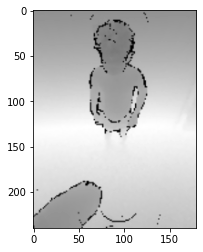

In [18]:
# paths = '../testdepthmap1/1585551618-hlby208u8z/pc_1585551618-hlby208u8z_1593156356859_100_000.p'
paths = REPO_DIR / "data/anon-realtime-testdata/scans/1584995101-drh9xoy38u/100/pc_1584995101-drh9xoy38u_1591550757076_100_000.p"

depthmap, targets = pickle.load(open(paths, "rb"))
depthmap = preprocess_depthmap(depthmap)
depthmap = depthmap / depthmap.max()
print("depthmap_max:", depthmap.max())
depthmap = tf.image.resize(depthmap, (DATA_CONFIG.IMAGE_TARGET_HEIGHT, DATA_CONFIG.IMAGE_TARGET_WIDTH))
targets = preprocess_targets(targets, DATA_CONFIG.TARGET_INDEXES)
depthmap.set_shape((DATA_CONFIG.IMAGE_TARGET_HEIGHT, DATA_CONFIG.IMAGE_TARGET_WIDTH, 1))
# targets.set_shape((len(targets_indices,)))
plt.imshow(np.squeeze(depthmap), cmap='gray', vmin=0., vmax=1.);

### Perform the prediction

In [19]:
prediction_folder = glob2.glob(DATASET_PATH); print(prediction_folder[:3])
print(len(prediction_folder))
prediction_folder = prediction_folder[:40]  # reduce size for DEBUG speed

predictions = []
file_names = []
targets_list = []
for qrcode in tqdm(prediction_folder):
    depthfiles = []
    depthmaps = glob2.glob(qrcode + '/*.p')
    files = depthmaps[0]
    depths, targets = preprocess(files)

    sample = np.expand_dims(depths, axis=0)
    
    inference = model.predict(sample)
    file_names.append(files)
    predictions.append(np.squeeze(inference))
    targets_list.append(targets)

['/Users/markus/Development/cgm/cgm-ml/data/anon-realtime-testdata/scans/1585012497-rh1bch7sbd/102', '/Users/markus/Development/cgm/cgm-ml/data/anon-realtime-testdata/scans/1585012497-rh1bch7sbd/100', '/Users/markus/Development/cgm/cgm-ml/data/anon-realtime-testdata/scans/1585012497-rh1bch7sbd/101']
65


In [20]:
TARGET_INDEXES=[0, 3, 5]  # 0 is height, 5 is good/bad
def py_load_pickle(path, max_value=7.5):
    path_ = path if isinstance(path, str) else path.numpy()
    depthmap, targets = pickle.load(open(path_, "rb"))
    depthmap = preprocess_depthmap(depthmap)
    depthmap = depthmap / max_value
    depthmap = tf.image.resize(depthmap, (DATA_CONFIG.IMAGE_TARGET_HEIGHT, DATA_CONFIG.IMAGE_TARGET_WIDTH))
    targets = preprocess_targets(targets, TARGET_INDEXES)
    return depthmap, targets

def path_to_ndarray(pickle_file_path):
    depthmap, _targets = py_load_pickle(pickle_file_path)
    depthmap = tf.reshape(depthmap, (DATA_CONFIG.IMAGE_TARGET_HEIGHT, DATA_CONFIG.IMAGE_TARGET_WIDTH))
    return depthmap.numpy(), _targets

In [25]:
len(predictions), len(targets_list)

(40, 40)

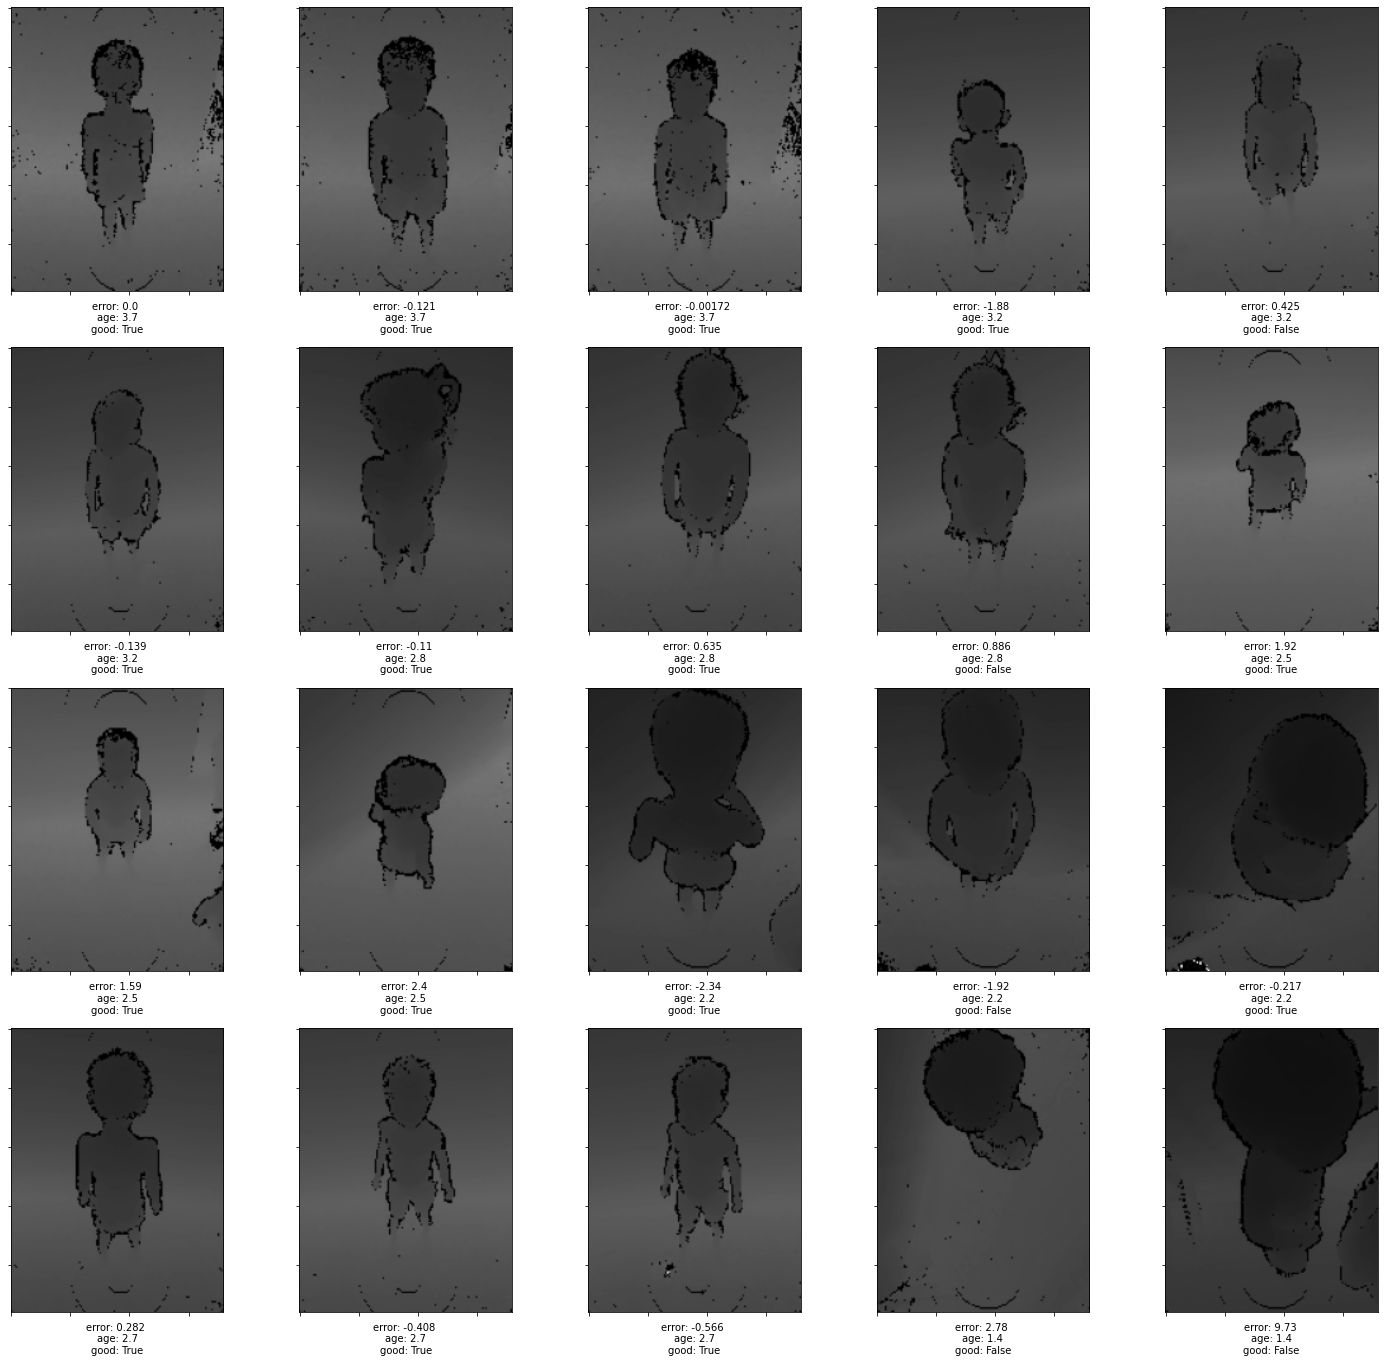

In [30]:
num_height, num_width = 4, 5
fig, axarr = plt.subplots(num_height, num_width, figsize=(25, 24))

for x in range(num_height):
    for y in range(num_width):
        i = x * num_width + y
        fpath = file_names[i]
        arr, targets = path_to_ndarray(fpath)
        axarr[x,y].imshow(arr, cmap='gray', vmin=0, vmax=0.5);  # vmax=1
        axarr[x,y].set_xticklabels([]); axarr[x,y].set_yticklabels([])
        error = float(predictions[i] - targets_list[i])
        label = f"error: {error:.3} \nage: {targets[1]/365:.2}\ngood: {bool(targets[2])}"
        axarr[x,y].set_xlabel(label)
plt.show()

In [23]:
# Setup for correlations
len(predictions), len(targets_list)

(40, 40)

In [24]:
assert len(predictions) == len(file_names) == len(targets_list)
print(len(predictions))

df = pd.DataFrame(
    {'predictions': predictions,
     'file_names': file_names,
     'targets_list': targets_list
    })
# Preproc
df['height_measured'] = df.targets_list.apply(lambda x: x[0])
df.drop(labels="targets_list", axis=1, inplace=True)
df['error'] = abs(df['height_measured'] - df['predictions'])

40


**Findings**
- For taller children the model is more certain.
- For older children the model is more certain.
- For good images the model is more certain.